# Análise do uso das redes sociais pelas candidaturas

[Voltar ao Índice](00_indice.ipynb)

Vamos realizar uma análise de estatística descritiva dos dados do TSE referentes ao uso de redes sociais pelas candidaturas. 
O objetivo é ter um panorama de quais são as redes sociais e recursos da web utilizados pelas candidaturas e as relações entre
esse uso e características das candidaturas.

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import scipy.stats as stats
import numpy as np
from importlib import reload

import src.analysis_functions as af
import xavy.dataframes as xd
import xavy.stats as xx
import xavy.plots as xp

## Carregando os dados

Vamos produzir uma tabela com uma linha por candidato mostrando quais as plataformas utilizadas por cada um. Também vamos juntar a cada candidato diversas características suas e do eleitorado da sua unidade.

In [2]:
# Carrega informações sobre o candidato, seus bens e sobre o número de eleitores na sua unidade eleitoral:
cand_df = af.load_cand_eleitorado_bens_votos('../dados/limpos/consulta_cand/consulta_cand_2022_BRASIL.csv',
                                             '../dados/limpos/perfil_eleitorado/perfil_eleitorado_2022.csv',
                                             '../dados/limpos/bens_candidatos/bem_candidato_2022_BRASIL.csv',
                                             '../dados/brutos/tse/votacao_candidato_munzona_2022/votacao_candidato_munzona_2022_BRASIL.csv')

In [3]:
# Carrega listagem de redes sociais de candidatos (uma linha por candidato+rede):
platform_regex = af.return_redes_regex()
redes_df = af.etl_tse_redes_sociais('../dados/brutos/tse/redes_sociais/rede_social_candidato_2022.csv', platform_regex)

In [4]:
# Cria tabela de uso de plataforma por usuário (uma linha por candidato):
redes_cols = list(platform_regex.keys()) + ['website', 'arroba', 'usuario']
use_df = af.platform_use_by_cand(cand_df, redes_df, redes_cols)
use_df['FRAC_VOTOS'] = use_df['QT_VOTOS_NOMINAIS'] / use_df['QT_ELEITORES_PERFIL'] * 1e8

In [5]:
# URLs do tipo selecionado:
#xd.print_string_series(redes_df.loc[(redes_df['beacons'] == 1), 'DS_URL'])

## Análise

### Estimativa de taxa de "não declaração" de redes sociais

Os dados do TSE sobre as redes sociais dos candidatos são declarados livremente pelos partidos no ato do registro das candidaturas, então eles não são completos.
Para estimar a fração dos candidatos que não declararam redes mas as têm, vamos buscar por suas redes manualmente no Google, utilizando uma amostra aleatória.
Por se tratar de um processo de amostragem aleatório e independente da população de candidatos sem redes declaradas, o resultado segue uma distribuição binomial.

In [6]:
# Seleção de amostra aleatória para busca das redes no google:
n_semredes = 100
#manual_check_df = use_df.query('nenhuma > 0')[['DS_CARGO', 'NM_URNA_CANDIDATO','SG_PARTIDO', 'SG_UF']].sample(n_semredes, random_state=12121)
#manual_check_df.to_csv('../dados/processados/candidatos_sem_redes_declaradas_2022.csv', index=False)

# Carregando resultado da busca sobre os candidatos acima (29/100 possuem redes):
manual_check_df = pd.read_csv('../dados/processados/candidatos_sem_redes_declaradas_2022.csv')
n_redes_ocultas = (manual_check_df['PLATAFORMA'] != 'Nenhuma').sum()

In [7]:
manual_check_df['PLATAFORMA'].value_counts()

Nenhuma      71
Instagram    13
Facebook     13
Website       3
Name: PLATAFORMA, dtype: int64

Fração dos "sem redes" que, na verdade, tem alguma rede: 0.301 +/- 0.045


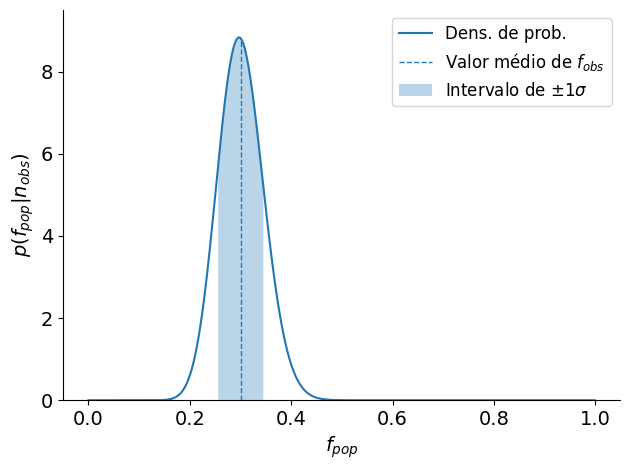

In [8]:
# Cálculo da probabilidade a posteriori da fração dos "sem rede" terem rede:
dp = 0.001
p, post = xx.triang_binom_posterior(0.7, n_semredes, n_redes_ocultas, dp)

# Cálculo do valor esperado e incerteza:
mean_p = (p * post * dp).sum()
mean_p2 = (p**2 * post * dp).sum()
dev_p = np.sqrt(mean_p2 - mean_p**2)
print('Fração dos "sem redes" que, na verdade, tem alguma rede: {:.3f} +/- {:.3f}'.format(mean_p, dev_p))

# Gráfico:
n_sigma = 1
# Densidade:
pl.plot(p, post, label='Dens. de prob.')
# Média:
pl.vlines(mean_p, 0, post[np.argmin((p - mean_p)**2)], linestyle='--', linewidth=1, label='Valor médio de $f_{obs}$')
# Desvio padrão:
pl.fill_between(p[(p > mean_p - n_sigma * dev_p) & (p < mean_p + n_sigma * dev_p)], post[(p > mean_p - n_sigma * dev_p) & (p < mean_p + n_sigma * dev_p)], alpha=0.3, label='Intervalo de $\pm 1 \sigma$')
# Formatação:
pl.xlabel('$f_{pop}$', fontsize=14)
pl.ylabel('$p(f_{pop}|n_{obs})$', fontsize=14)
pl.ylim([0, 9.5])
pl.tick_params(labelsize=14)
pl.legend(fontsize=12)
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.tight_layout()
#pl.savefig('../resultados/plots/fracao_rede-nao-declarada_posterior.png')
pl.show()

### Estimativa do uso das diferentes plataformas

A partir das redes declaradas ao TSE e da estimativa de redes não declaradas acima, vamos estimar a verdadeira presença das diversas plataformas nas candidaturas. Para tanto, vamos assumir as seguintes hipóteses:

1. Que a fração de candidaturas com redes sociais entre as que não declararam nenhuma é dada pelo valor esperado estimado acima;
2. Que as plataformas não declaradas se distribuem da mesma maneira que as declaradas, isto é, que a suas presenças nas candidaturas são todas corrigidas por um fator constante.

In [9]:
# Corrigindo os dados de uso de redes sociais pela fração estimada de redes não declaradas:
cand_per_platform = use_df[redes_cols].sum().sort_values()
cand_per_platform_fix = cand_per_platform.copy()
NTs = cand_per_platform_fix['nenhuma']
cand_per_platform_fix.loc['nenhuma'] = cand_per_platform_fix.loc['nenhuma'] * (1 - mean_p)
cand_per_platform_fix.loc[cand_per_platform_fix.index != 'nenhuma'] = cand_per_platform_fix.loc[cand_per_platform_fix.index != 'nenhuma'] * (1 + mean_p * NTs / (len(use_df) - NTs))

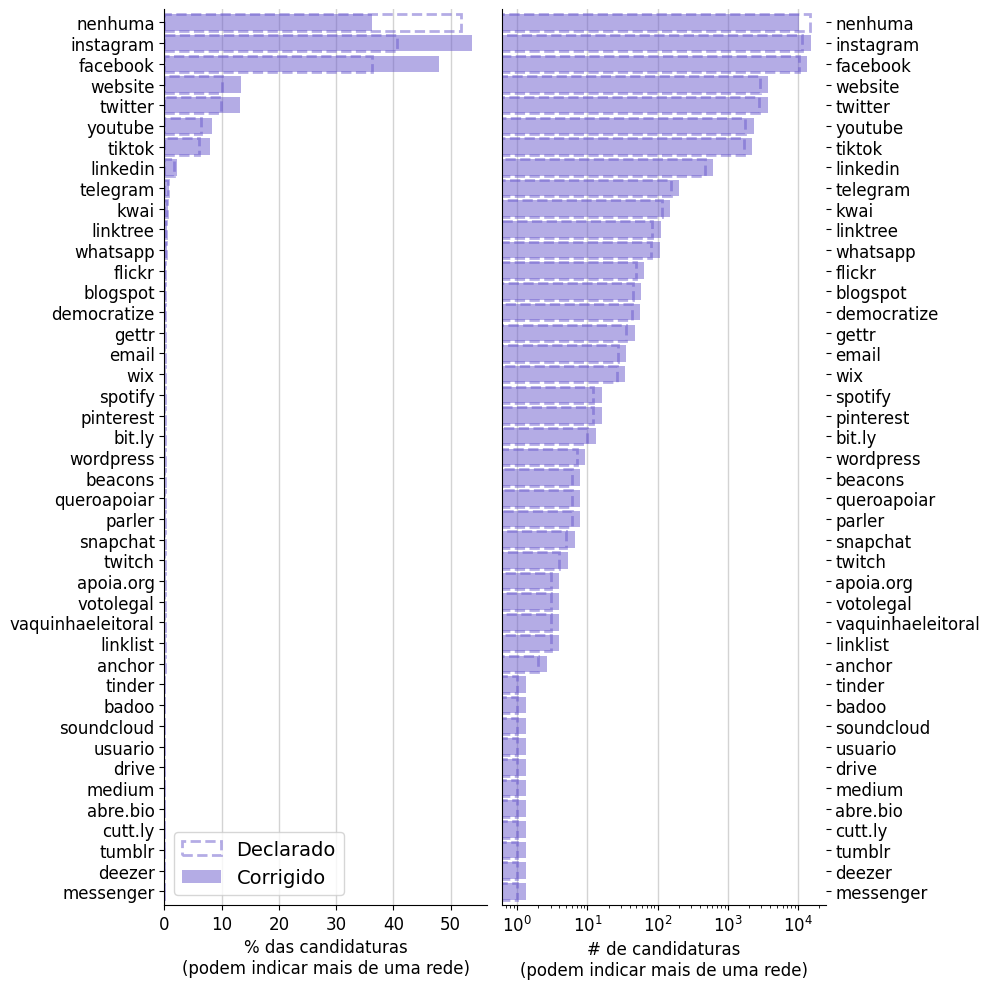

In [10]:
n_cands = len(use_df)
fig = af.plot_platform_counts(cand_per_platform, n_cands, facecolor='none', edgecolor='slateblue', linewidth=2, linestyle='--', alpha=0.5, label='Declarado')
fig = af.plot_platform_counts(cand_per_platform_fix, n_cands, labelsize=12, fig=fig, color='slateblue', alpha=0.5, label='Corrigido')
pl.subplot(1,2,1)
pl.legend(fontsize=14)
pl.tight_layout()
#pl.savefig('../resultados/plots/plataformas-utilizadas_2022.png')
pl.show()

Embora a hipótese 2 acima possa não ser exatamente válida, não acreditamos que uma eventual discrepância seja significativa a ponto de alterar a escala de grandeza da frequência de uso das diferentes plataformas. 

### Relação entre as diferentes dimensões das candidaturas

In [36]:
use_df['DS_CARGO'].value_counts()

DEPUTADO ESTADUAL     16233
DEPUTADO FEDERAL      10271
DEPUTADO DISTRITAL      591
2º SUPLENTE             237
1º SUPLENTE             236
SENADOR                 235
VICE-GOVERNADOR         224
GOVERNADOR              223
PRESIDENTE               12
VICE-PRESIDENTE          12
Name: DS_CARGO, dtype: int64

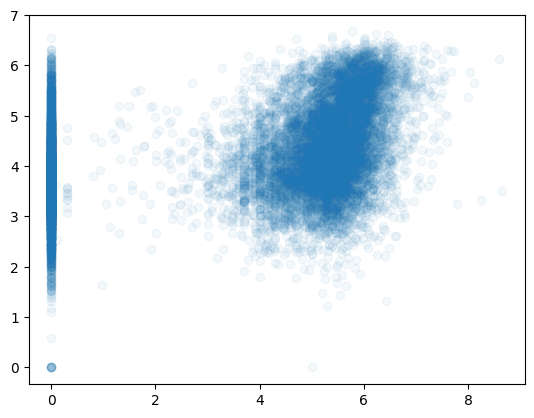

In [42]:
feat_num = ['NR_IDADE_DATA_POSSE', 'VALOR_TOTAL_BENS', 'QT_VOTOS_NOMINAIS', 'FRAC_VOTOS']
sel_df = use_df.query('DS_CARGO == "DEPUTADO ESTADUAL"')

#pl.scatter(use_df[feat_num[0]], np.log10(1 + use_df[feat_num[2]]), alpha=0.05)
pl.scatter(np.log10(1 + sel_df[feat_num[1]]), np.log10(1 + sel_df[feat_num[3]]), alpha=0.05)

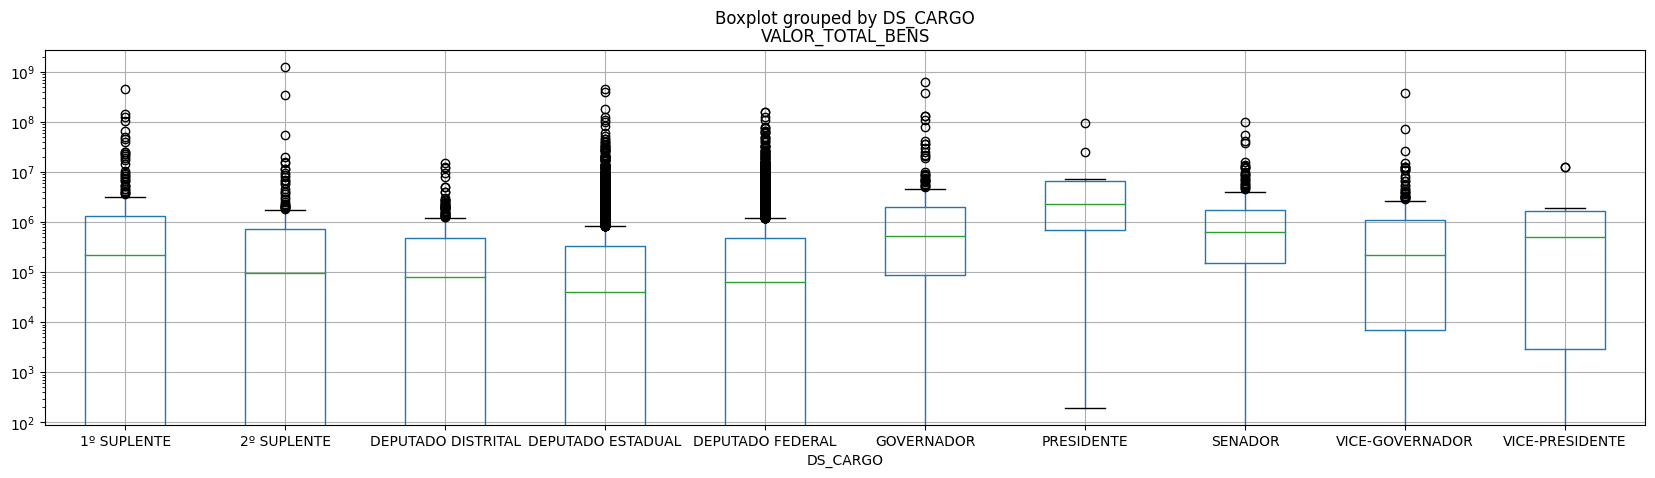

In [54]:
use_df.boxplot('VALOR_TOTAL_BENS', by='DS_CARGO', figsize=(20,5))
pl.yscale('log')
pl.show()

### Relação do uso de plataformas com dimensões dos candidatos

Vamos verificar como a declaração de cada plataforma está relacionada com as características dos candidatos.

#### Idade

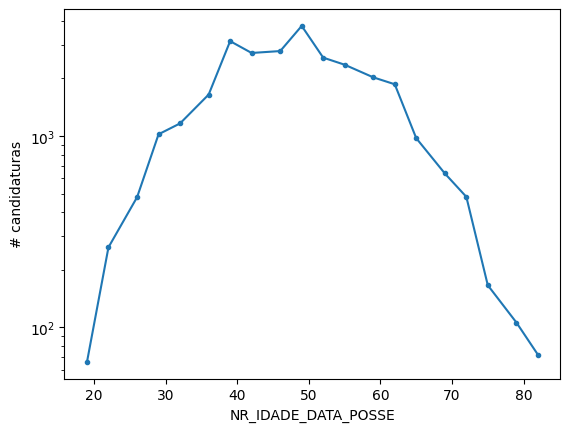

In [15]:
# Definindo os bins:
af.plot_bin_counts(use_df['NR_IDADE_DATA_POSSE'], 20, 18, 84)

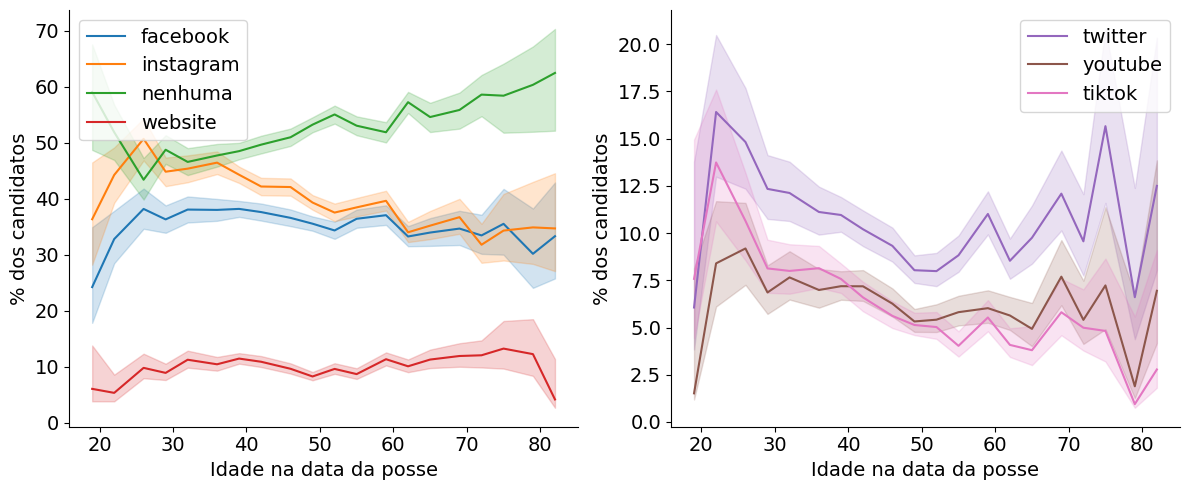

In [24]:
# Gráfico:
dim = 'NR_IDADE_DATA_POSSE'
n_bins = 20
lower_clip = 18
upper_clip = 84

pl.figure(figsize=(12,5))
pl.subplot(1,2,1)
af.plot_usage_frac_by_dimension(use_df, ['facebook', 'instagram', 'nenhuma', 'website'], dim, n_bins, lower_clip, upper_clip, legend_size=14, xlabel='Idade na data da posse')
pl.subplot(1,2,2)
af.plot_usage_frac_by_dimension(use_df, ['twitter', 'youtube', 'tiktok'], dim, n_bins, lower_clip, upper_clip, coffset=4, legend_size=14, xlabel='Idade na data da posse')
pl.tight_layout()
#pl.savefig('../resultados/plots/uso-plataformas-por-dimensao_2022_idade.png')
pl.show()

#### Bens declarados

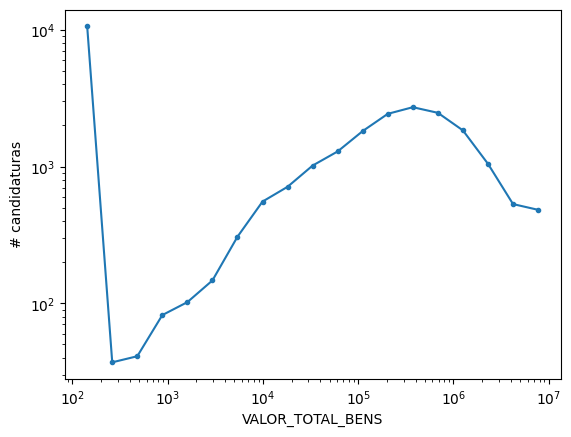

In [11]:
# Definindo os bins:
af.plot_bin_counts(use_df['VALOR_TOTAL_BENS'], 19, 101, 1e7, logscale=True)

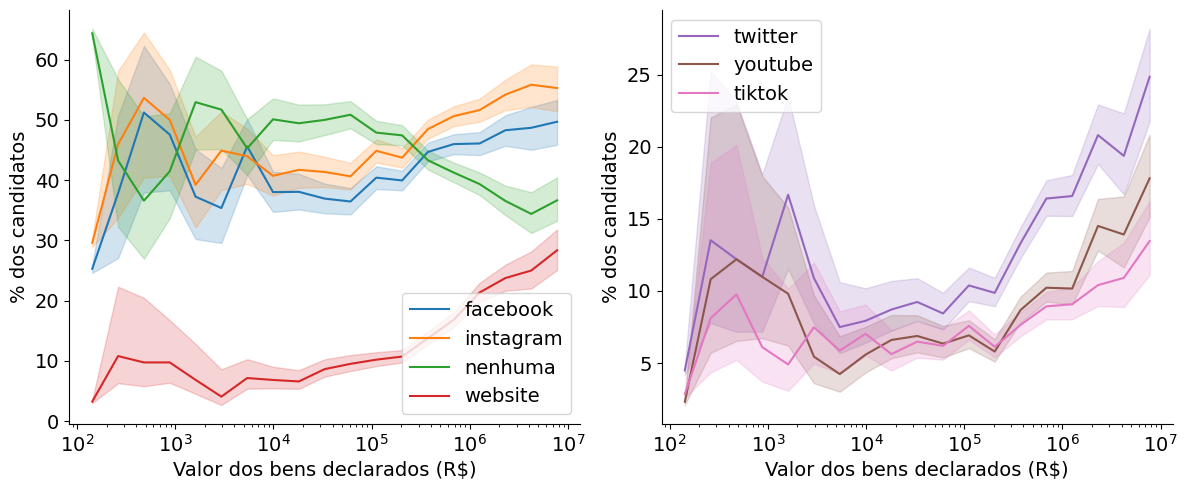

In [24]:
# Gráfico:
dim = 'VALOR_TOTAL_BENS'
n_bins = 19
lower_clip = 101
upper_clip = 1e7

pl.figure(figsize=(12,5))
pl.subplot(1,2,1)
af.plot_usage_frac_by_dimension(use_df, ['facebook', 'instagram', 'nenhuma', 'website'], dim, n_bins, lower_clip, upper_clip, logscale=True, legend_size=14, xlabel='Valor dos bens declarados (R$)')
pl.subplot(1,2,2)
af.plot_usage_frac_by_dimension(use_df, ['twitter', 'youtube', 'tiktok'], dim, n_bins, lower_clip, upper_clip, coffset=4, logscale=True, legend_size=14, xlabel='Valor dos bens declarados (R$)')
pl.tight_layout()
#pl.savefig('../resultados/plots/uso-plataformas-por-dimensao_2022_bens.png')
pl.show()

#### Quantidade de votos

No caso da quantidade de votos obtidos, os cargos aos quais os candidatos estão concorrendo pode distorcer a análise: cargos majoritários (senadores, presidentes, governadores) tendem a ter muito mais votos do que cargos proporcionais (deputados), mesmo se ponderarmos pelo tamanho do colégio eleitoral (para retirar efeitos de unidades com eleitorados de tamanhos muito diferentes). Por isso, faremos a análise apenas para deputados.

In [55]:
# Seleção dos deputados:
deps_use_df = use_df.loc[use_df['DS_CARGO'].isin(['DEPUTADO FEDERAL', 'DEPUTADO ESTADUAL', 'DEPUTADO DISTRITAL'])]

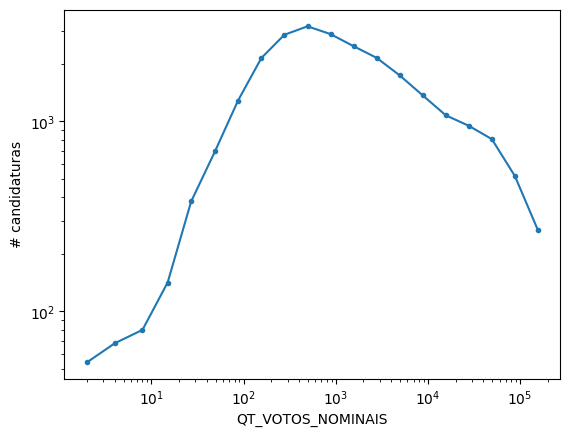

In [56]:
# Definindo os bins:
af.plot_bin_counts(deps_use_df['QT_VOTOS_NOMINAIS'], 20, 2, 2e5, logscale=True)

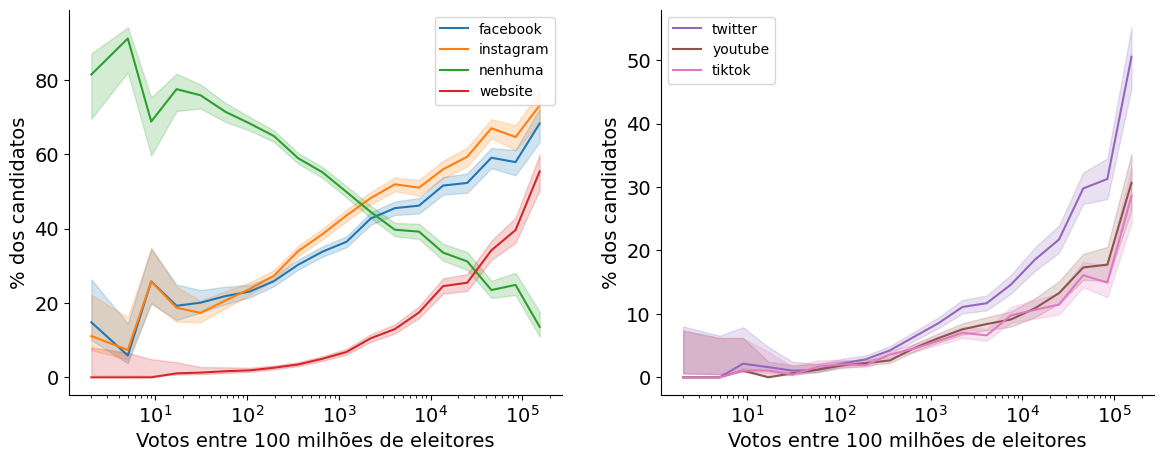

In [61]:
# Gráfico:
dim = 'QT_VOTOS_NOMINAIS'
n_bins = 19
lower_clip = 2
upper_clip = 2e5

pl.figure(figsize=(14,5))
pl.subplot(1,2,1)
af.plot_usage_frac_by_dimension(deps_use_df, ['facebook', 'instagram', 'nenhuma', 'website'], dim, n_bins, lower_clip, upper_clip, logscale=True, xlabel='Votos entre 100 milhões de eleitores')
pl.subplot(1,2,2)
af.plot_usage_frac_by_dimension(deps_use_df, ['twitter', 'youtube', 'tiktok'], dim, n_bins, lower_clip, upper_clip, coffset=4, logscale=True, xlabel='Votos entre 100 milhões de eleitores')
pl.tight_layout()

pl.show()

O resultado acima não compara os candidatos em termos de popularidade na sua unidade eleitoral, pois existem unidades com mais eleitores do que outras.
Para isolar esse efeito, vamos verificar o uso das plataformas em função de um número de eleitores de referência, de 100 milhões. 

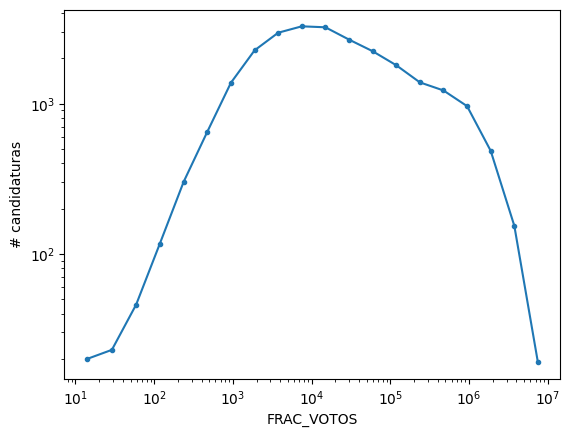

In [58]:
# Definindo os bins:
af.plot_bin_counts(deps_use_df['FRAC_VOTOS'], 20, 10, 1e7, logscale=True)

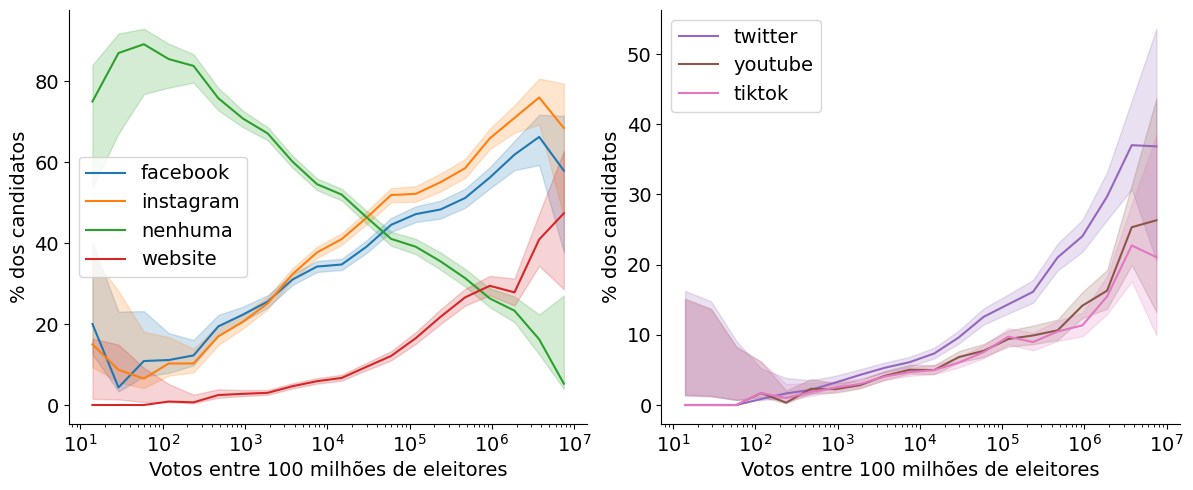

In [64]:
# Gráfico:
dim = 'FRAC_VOTOS'
n_bins = 20
lower_clip = 10
upper_clip = 1e7

pl.figure(figsize=(12,5))
pl.subplot(1,2,1)
af.plot_usage_frac_by_dimension(deps_use_df, ['facebook', 'instagram', 'nenhuma', 'website'], dim, n_bins, lower_clip, upper_clip, logscale=True, legend_size=14, xlabel='Votos entre 100 milhões de eleitores')
pl.subplot(1,2,2)
af.plot_usage_frac_by_dimension(deps_use_df, ['twitter', 'youtube', 'tiktok'], dim, n_bins, lower_clip, upper_clip, coffset=4, logscale=True, legend_size=14, xlabel='Votos entre 100 milhões de eleitores', legend_loc='upper left')
pl.tight_layout()
#pl.savefig('../resultados/plots/uso-plataformas-por-dimensao_2022_votos.png')
pl.show()

Ao invés de calcularmos quantas candidaturas em cada bin de votos possuem uma dada plataforma, podemos verificar a distribuição de votos para as candidaturas que utilizam cada plataforma. Os gráficos abaixo mostram como essa distribuição se altera quando selecionamos candidaturas que declararam uma determinada plataforma, em comparação com as que não declararam.

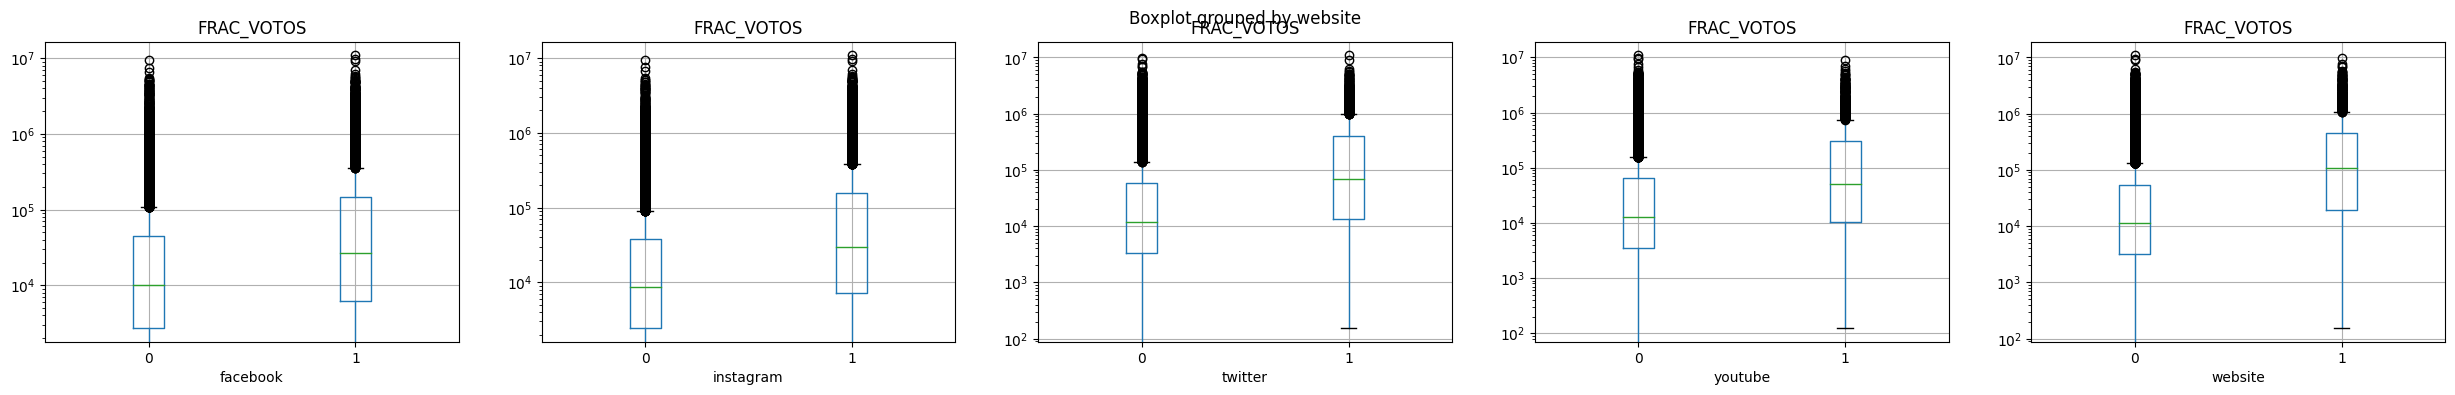

In [78]:
pl.figure(figsize=(30,4))
for i, c in enumerate(['facebook', 'instagram', 'twitter', 'youtube', 'website']):
    ax = pl.subplot(1,5,1 + i)
    deps_use_df.boxplot('FRAC_VOTOS', by=c, ax=ax)
    pl.yscale('log')
pl.show()

#### Cor/raça

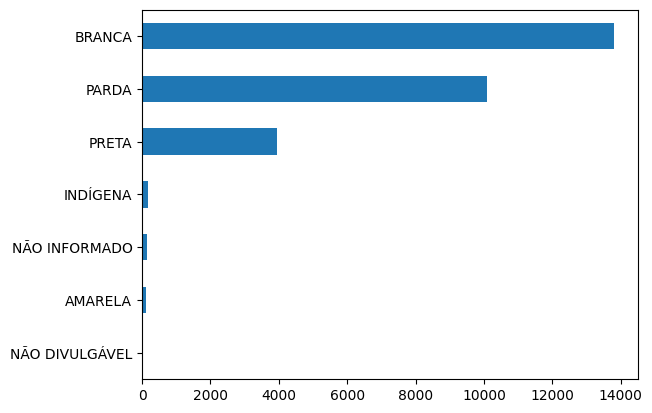

In [86]:
# Número de candidaturas em cada categoria:
use_df['DS_COR_RACA'].value_counts().sort_values().plot(kind='barh')
pl.show()

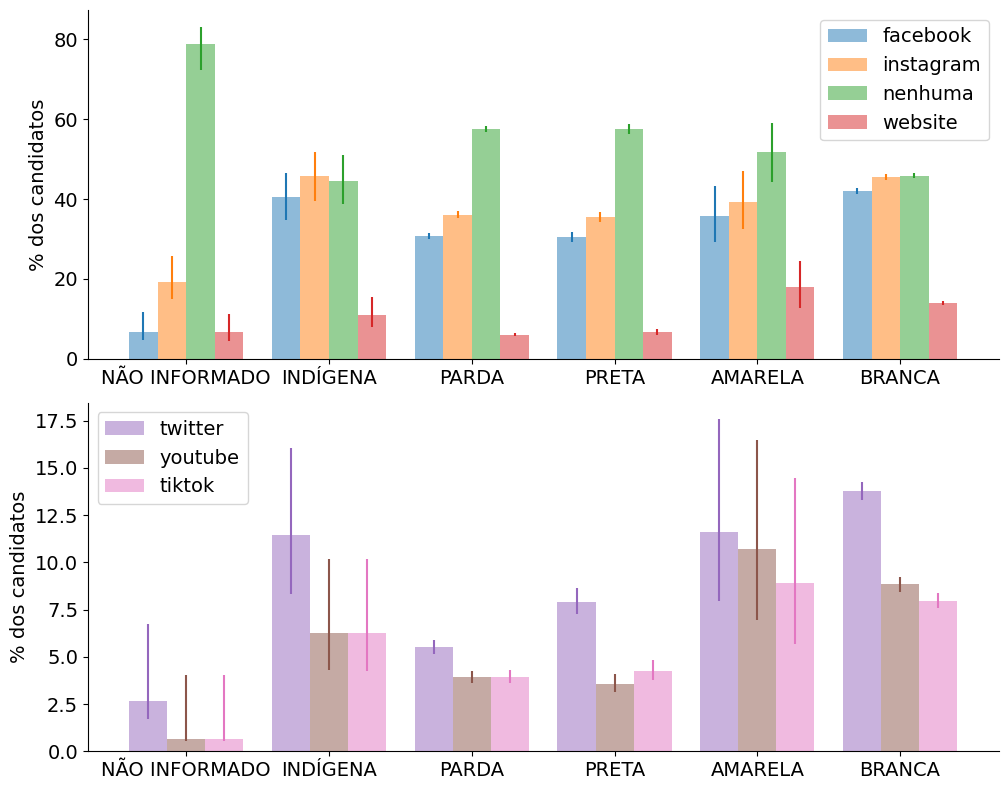

In [81]:
dim = 'DS_COR_RACA'
categories = ['NÃO INFORMADO', 'INDÍGENA', 'PARDA', 'PRETA', 'AMARELA', 'BRANCA']

pl.figure(figsize=(10, 8))
pl.subplot(2,1,1)
af.plot_usage_frac_by_dimension(use_df, ['facebook', 'instagram', 'nenhuma', 'website'], dim, categories, legend_size=14)
pl.subplot(2,1,2)
af.plot_usage_frac_by_dimension(use_df, ['twitter', 'youtube', 'tiktok'], dim, categories, coffset=4, legend_size=14)
pl.tight_layout()
#pl.savefig('../resultados/plots/uso-plataformas-por-dimensao_2022_cor-raca.png')
pl.show()

#### Gênero

In [6]:
fracs = use_df.groupby('DS_GENERO')[['facebook', 'instagram', 'nenhuma', 'website', 'twitter', 'youtube', 'tiktok']].mean()
fracs

,facebook,instagram,nenhuma,website,twitter,youtube,tiktok
DS_GENERO,,,,,,,
FEMININO,0.346268,0.401233,0.529556,0.074421,0.085584,0.046566,0.052094
MASCULINO,0.370076,0.408197,0.512910,0.113727,0.105986,0.071152,0.063517
NÃO DIVULGÁVEL,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
fracs.columns

Index(['facebook', 'instagram', 'nenhuma', 'website', 'twitter', 'youtube',
       'tiktok'],
      dtype='object')

In [12]:
fracs.loc['MASCULINO'] - fracs.loc['FEMININO'] 

facebook     0.023807
instagram    0.006964
nenhuma     -0.016645
website      0.039306
twitter      0.020402
youtube      0.024586
tiktok       0.011423
dtype: float64

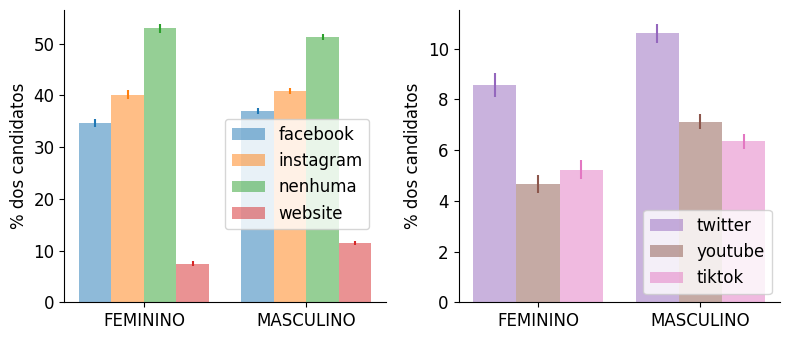

In [24]:
dim = 'DS_GENERO'
categories = ['FEMININO', 'MASCULINO']

pl.figure(figsize=(8, 3.5))
pl.subplot(1,2,1)
af.plot_usage_frac_by_dimension(use_df, ['facebook', 'instagram', 'nenhuma', 'website'], dim, categories, legend_size=12, legend_loc=(0.5,0.25), labelsize=12)
pl.subplot(1,2,2)
af.plot_usage_frac_by_dimension(use_df, ['twitter', 'youtube', 'tiktok'], dim, categories, coffset=4, legend_size=12, legend_loc='lower right', labelsize=12)
pl.tight_layout()
#pl.savefig('../resultados/plots/uso-plataformas-por-dimensao_2022_genero.png')
pl.show()

#### Escolaridade

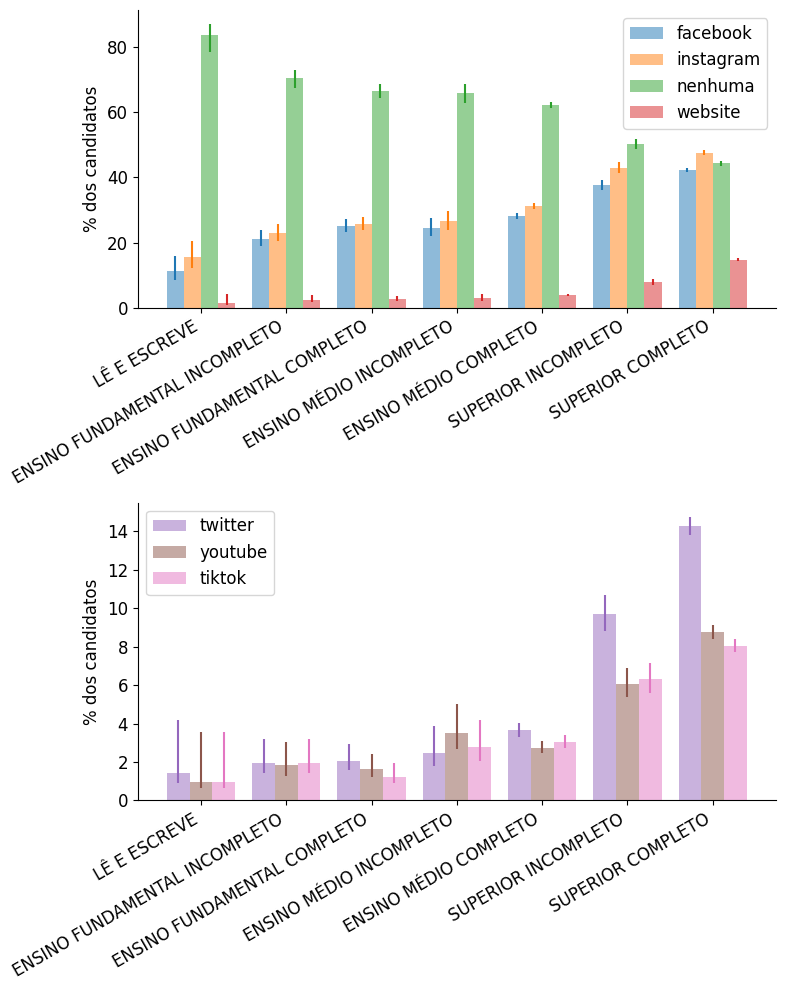

In [13]:
dim = 'DS_GRAU_INSTRUCAO'
categories = ['LÊ E ESCREVE', 'ENSINO FUNDAMENTAL INCOMPLETO', 'ENSINO FUNDAMENTAL COMPLETO', 'ENSINO MÉDIO INCOMPLETO', 'ENSINO MÉDIO COMPLETO', 'SUPERIOR INCOMPLETO', 'SUPERIOR COMPLETO']

pl.figure(figsize=(8, 10))
pl.subplot(2,1,1)
af.plot_usage_frac_by_dimension(use_df, ['facebook', 'instagram', 'nenhuma', 'website'], dim, categories, legend_size=12, label_rot=30, labelsize=12)
pl.subplot(2,1,2)
af.plot_usage_frac_by_dimension(use_df, ['twitter', 'youtube', 'tiktok'], dim, categories, coffset=4, legend_size=12, label_rot=30, labelsize=12)
pl.tight_layout()
#pl.savefig('../resultados/plots/uso-plataformas-por-dimensao_2022_escolaridade.png')
pl.show()

#### Cargo

In [31]:
use_df.groupby('DS_CARGO')['nenhuma'].mean().sort_values()

DS_CARGO
PRESIDENTE            0.083333
VICE-PRESIDENTE       0.166667
GOVERNADOR            0.251121
SENADOR               0.353191
DEPUTADO DISTRITAL    0.368866
VICE-GOVERNADOR       0.392857
DEPUTADO FEDERAL      0.510272
DEPUTADO ESTADUAL     0.534159
1º SUPLENTE           0.631356
2º SUPLENTE           0.645570
Name: nenhuma, dtype: float64

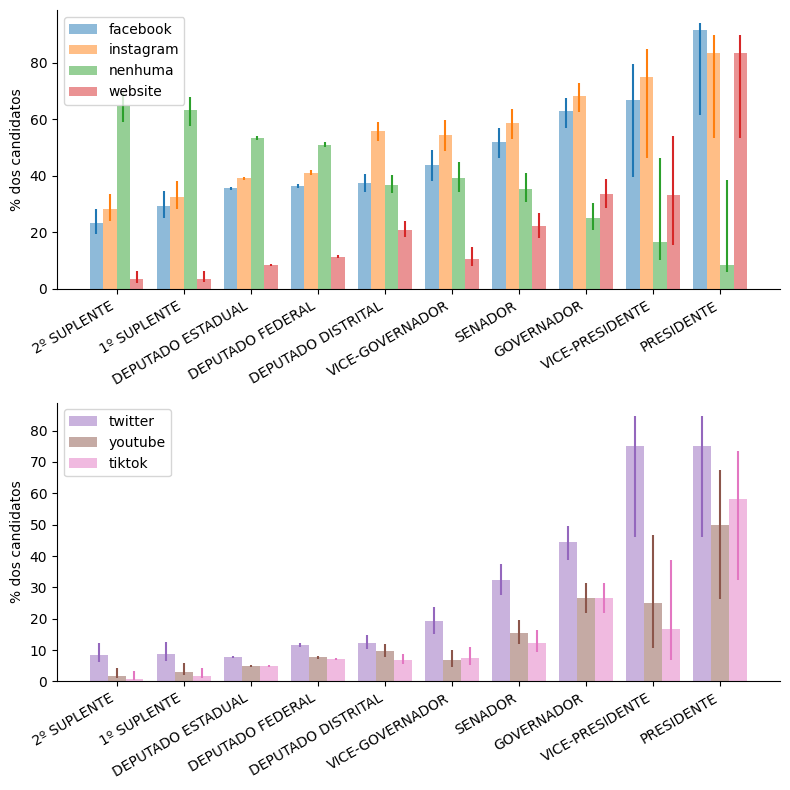

In [21]:
dim = 'DS_CARGO'
categories = ['2º SUPLENTE', '1º SUPLENTE', 'DEPUTADO ESTADUAL', 'DEPUTADO FEDERAL', 'DEPUTADO DISTRITAL', 'VICE-GOVERNADOR', 'SENADOR', 'GOVERNADOR', 'VICE-PRESIDENTE', 'PRESIDENTE']

pl.figure(figsize=(8, 8))
pl.subplot(2,1,1)
af.plot_usage_frac_by_dimension(use_df, ['facebook', 'instagram', 'nenhuma', 'website'], dim, categories, legend_size=10, label_rot=30, labelsize=10)
pl.subplot(2,1,2)
af.plot_usage_frac_by_dimension(use_df, ['twitter', 'youtube', 'tiktok'], dim, categories, coffset=4, legend_size=10, label_rot=30, labelsize=10)
pl.tight_layout()
#pl.savefig('../resultados/plots/uso-plataformas-por-dimensao_2022_cargo.png')
pl.show()

### Relação entre características dos candidatos

As várias características das candidaturas estão correlacionadas entre si. Vamos verificar isso a partir dos dados, comparando com amostras de correlação aleatórias.

Os gráficos abaixo comparam a fração observada de candidaturas que caem dentro de um subgrupo formado por um par de características 
(e.g. ENSINO MÉDIO COMPLETO e FEMININO) com a frações que seriam esperadas em caso das duas dimensões (e.g. escolaridade e gênero) não estarem correlacionadas.

#### Gênero e cargo pretendido

In [38]:
sel_df  = cand_df.query('DS_GENERO != "NÃO DIVULGÁVEL"')
dimensions = ['DS_GENERO', 'DS_CARGO']
obs_frac = xx.frac_by_categories(sel_df[dimensions])
resampled_stats = xx.resample_stats(sel_df[dimensions], frac_by_categories).fillna(0)

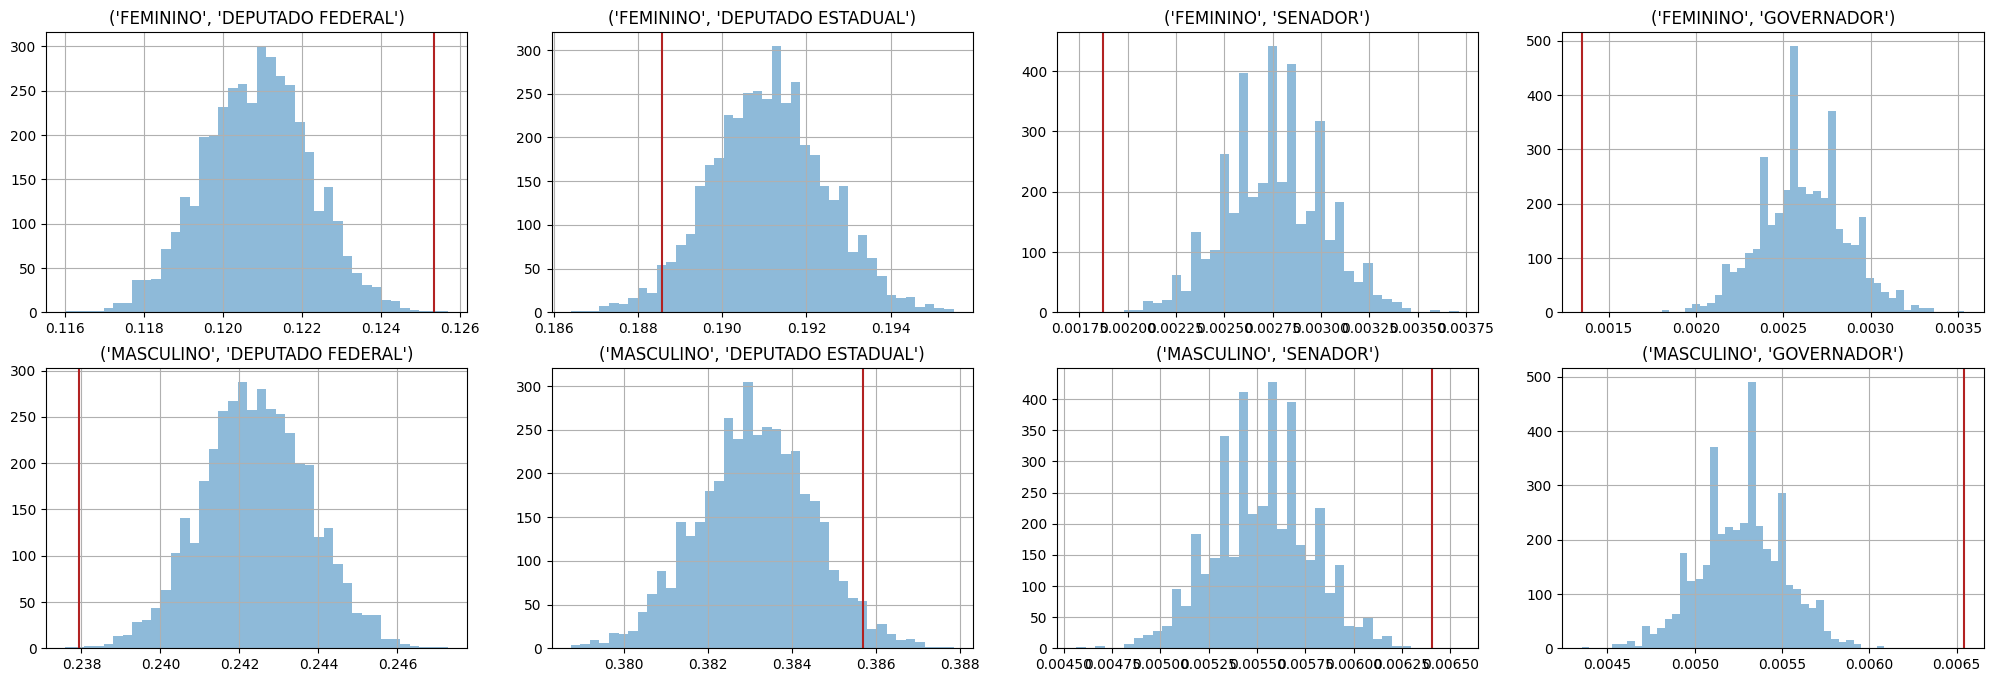

In [39]:
pl.figure(figsize=(25,8))
for i, subgroup in enumerate([('FEMININO', 'DEPUTADO FEDERAL'), ('FEMININO', 'DEPUTADO ESTADUAL'), ('FEMININO', 'SENADOR'), ('FEMININO', 'GOVERNADOR'),
                              ('MASCULINO', 'DEPUTADO FEDERAL'), ('MASCULINO', 'DEPUTADO ESTADUAL'), ('MASCULINO', 'SENADOR'), ('MASCULINO', 'GOVERNADOR')]):
    pl.subplot(2,4,i + 1)
    resampled_stats.loc[subgroup].hist(bins=40, alpha=0.5)
    pl.axvline(obs_frac[subgroup], color='firebrick')
    pl.title(subgroup)
pl.show()

#### Raça e cargo pretendido

In [15]:
sel_df  = cand_df
dimensions = ['DS_COR_RACA', 'DS_CARGO']
obs_frac = xx.frac_by_categories(sel_df[dimensions])
resampled_stats = xx.resample_stats(sel_df[dimensions], frac_by_categories).fillna(0)

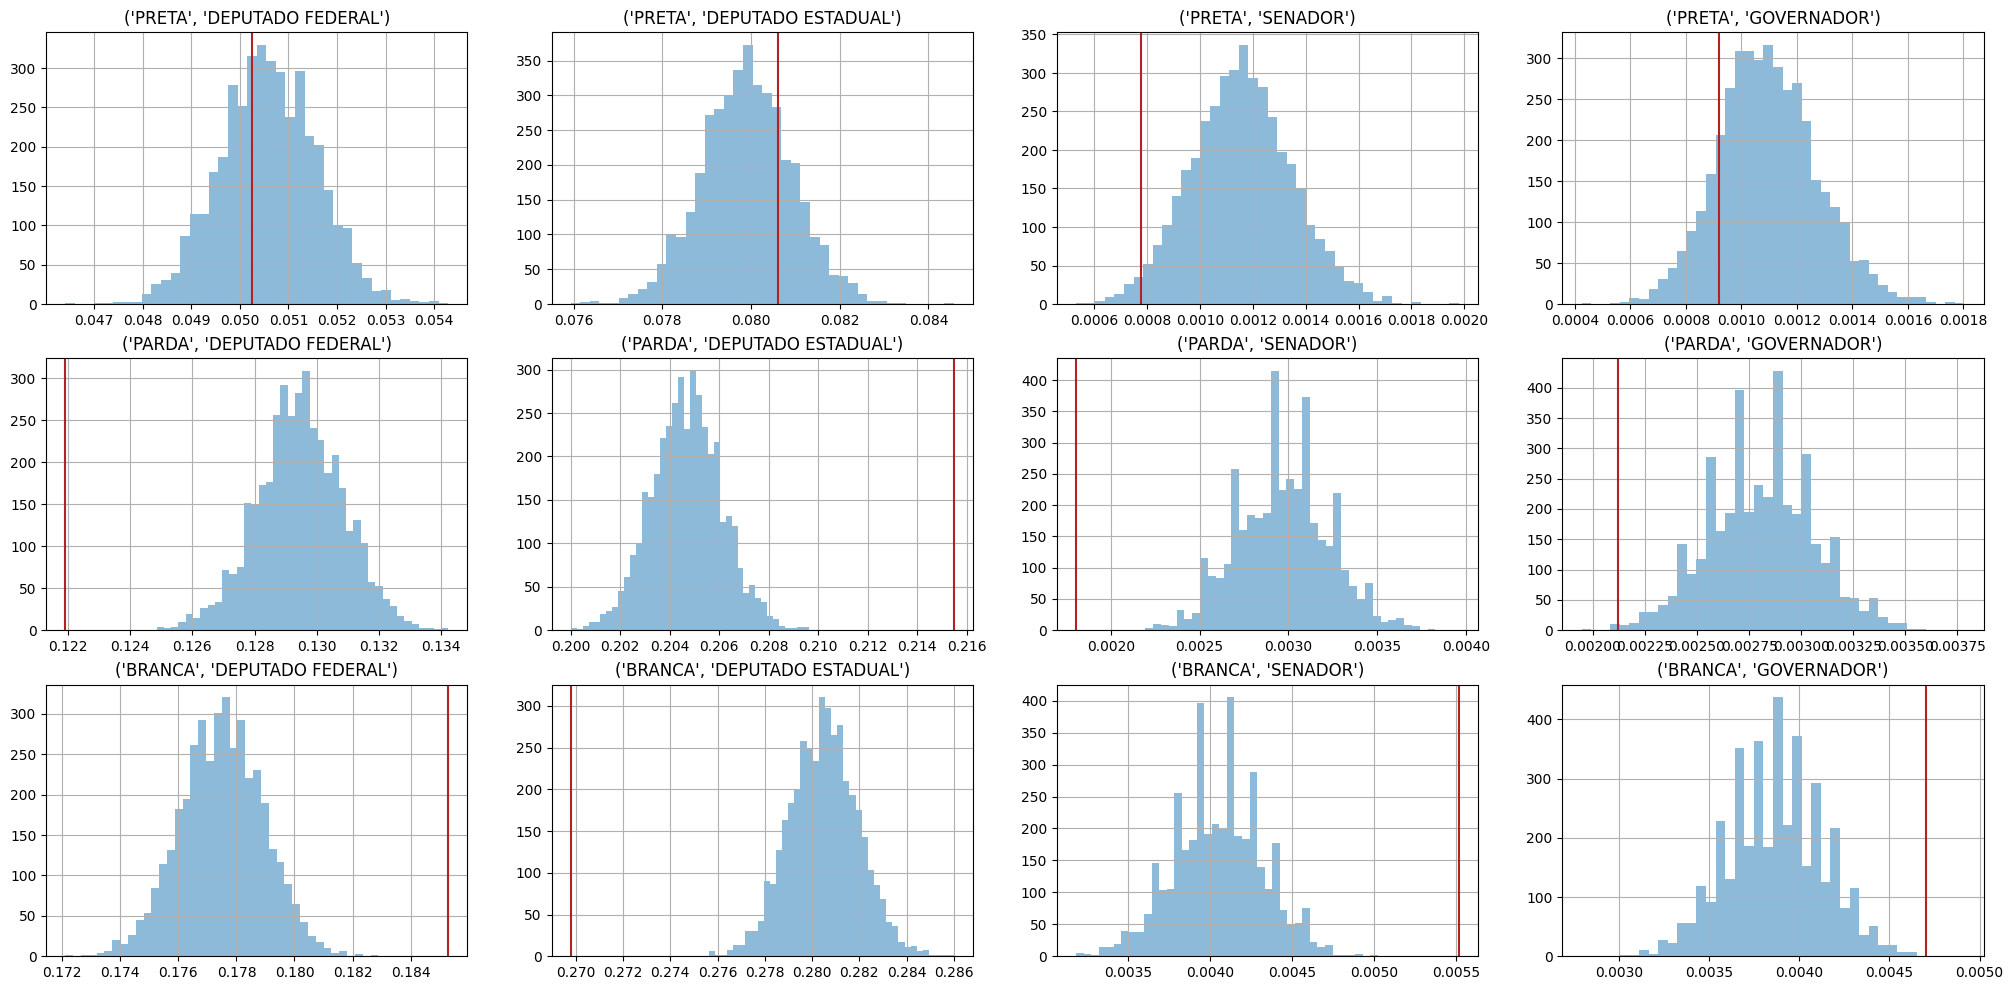

In [18]:
pl.figure(figsize=(25,12))
for i, subgroup in enumerate([('PRETA', 'DEPUTADO FEDERAL'), ('PRETA', 'DEPUTADO ESTADUAL'), ('PRETA', 'SENADOR'), ('PRETA', 'GOVERNADOR'),
                              ('PARDA', 'DEPUTADO FEDERAL'), ('PARDA', 'DEPUTADO ESTADUAL'), ('PARDA', 'SENADOR'), ('PARDA', 'GOVERNADOR'),
                              ('BRANCA', 'DEPUTADO FEDERAL'), ('BRANCA', 'DEPUTADO ESTADUAL'), ('BRANCA', 'SENADOR'), ('BRANCA', 'GOVERNADOR')]):
    pl.subplot(3,4,i + 1)
    resampled_stats.loc[subgroup].hist(bins=40, alpha=0.5)
    pl.axvline(obs_frac[subgroup], color='firebrick')
    pl.title(subgroup)
pl.show()

#### Raça e escolaridade

In [19]:
sel_df  = cand_df
dimensions = ['DS_COR_RACA', 'DS_GRAU_INSTRUCAO']
obs_frac = xx.frac_by_categories(sel_df[dimensions])
resampled_stats = xx.resample_stats(sel_df[dimensions], frac_by_categories).fillna(0)

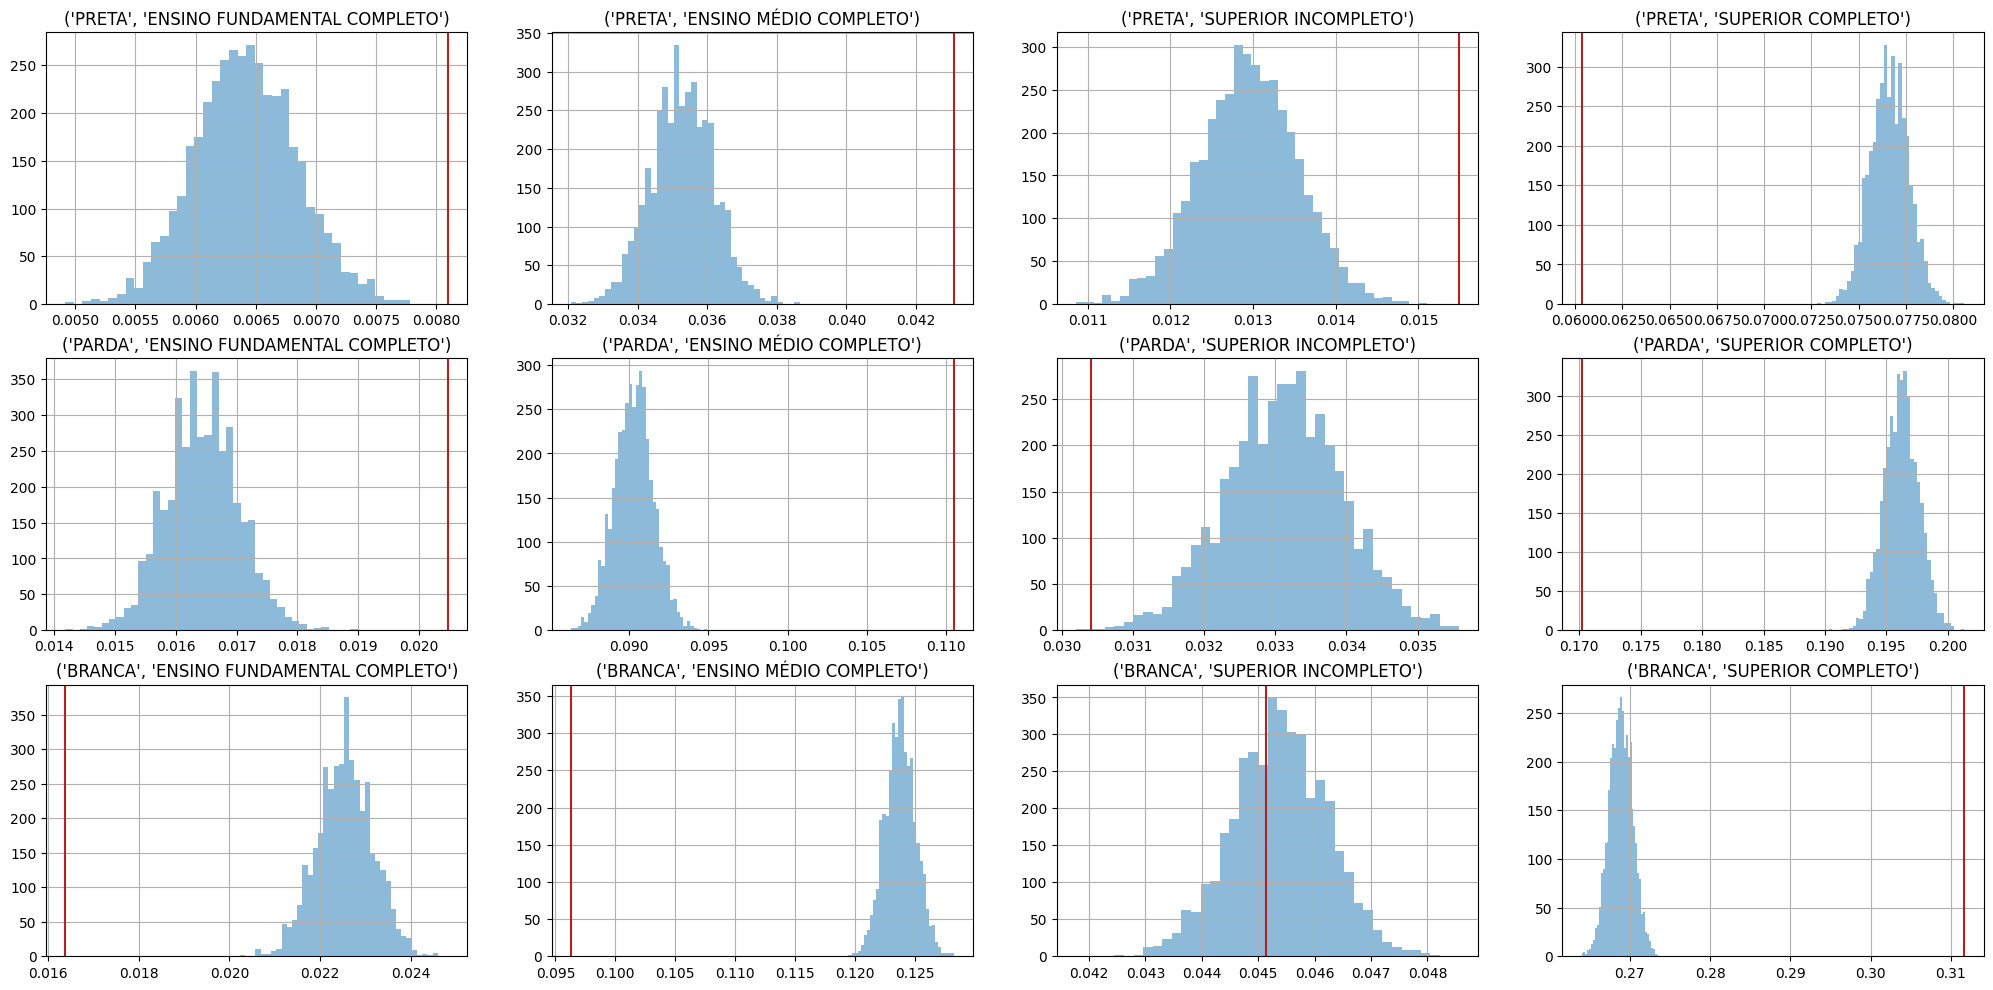

In [22]:
pl.figure(figsize=(25,12))
for i, subgroup in enumerate([('PRETA', 'ENSINO FUNDAMENTAL COMPLETO'), ('PRETA', 'ENSINO MÉDIO COMPLETO'), ('PRETA', 'SUPERIOR INCOMPLETO'), ('PRETA', 'SUPERIOR COMPLETO'),
                              ('PARDA', 'ENSINO FUNDAMENTAL COMPLETO'), ('PARDA', 'ENSINO MÉDIO COMPLETO'), ('PARDA', 'SUPERIOR INCOMPLETO'), ('PARDA', 'SUPERIOR COMPLETO'),
                              ('BRANCA', 'ENSINO FUNDAMENTAL COMPLETO'), ('BRANCA', 'ENSINO MÉDIO COMPLETO'), ('BRANCA', 'SUPERIOR INCOMPLETO'), ('BRANCA', 'SUPERIOR COMPLETO')]):
    pl.subplot(3,4,i + 1)
    resampled_stats.loc[subgroup].hist(bins=40, alpha=0.5)
    pl.axvline(obs_frac[subgroup], color='firebrick')
    pl.title(subgroup)
pl.show()

#### Raça e bens

In [40]:
dimensions = ['DS_COR_RACA', 'VALOR_TOTAL_BENS']
# Binando valores reais:
sel_df = cand_df[dimensions].copy()
sel_df.iloc[:, -1] = af.values_to_bins(sel_df.iloc[:, -1], 7, 101, 1e7, logscale=True)
# Prossegue no trabalho normal:
obs_frac = xx.frac_by_categories(sel_df[dimensions])
resampled_stats = xx.resample_stats(sel_df[dimensions], frac_by_categories).fillna(0)

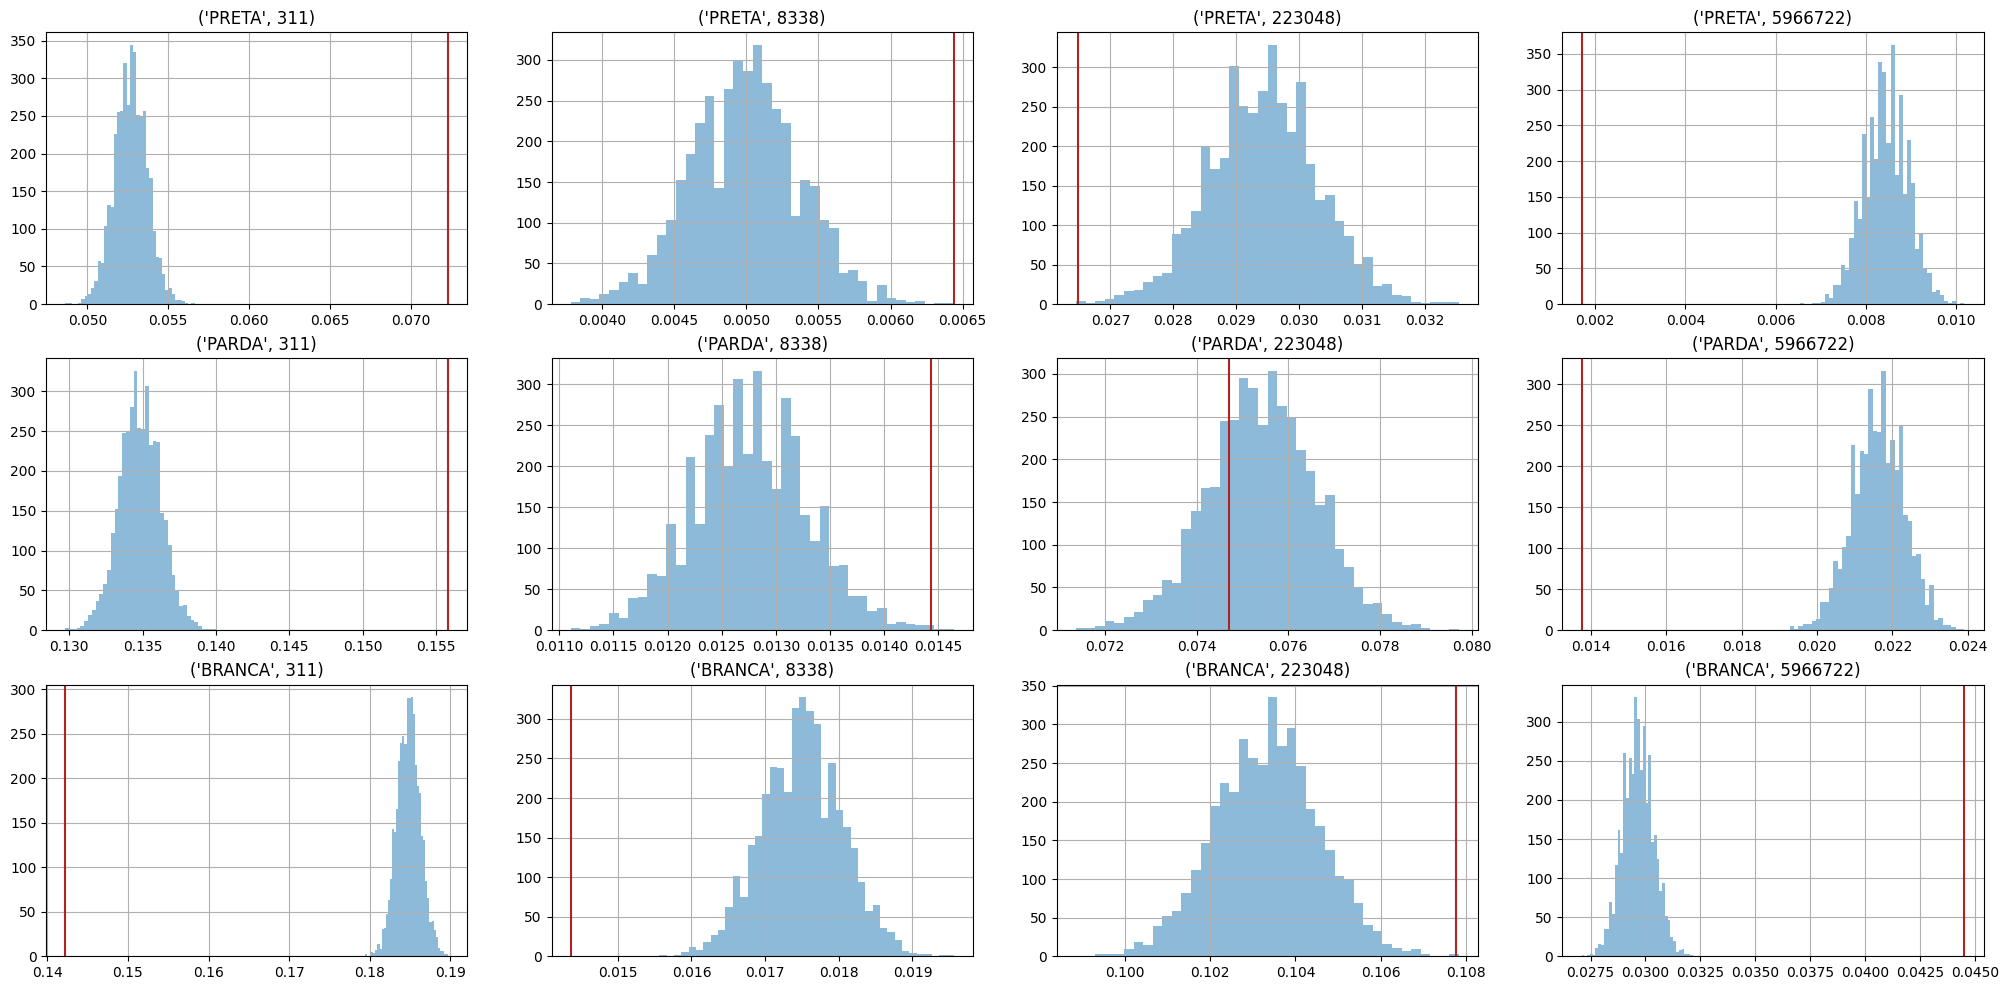

In [41]:
pl.figure(figsize=(25,12))
for i, subgroup in enumerate([('PRETA', 311), ('PRETA', 8338), ('PRETA', 223048), ('PRETA', 5966722),
                              ('PARDA', 311), ('PARDA', 8338), ('PARDA', 223048), ('PARDA', 5966722),
                              ('BRANCA', 311), ('BRANCA', 8338), ('BRANCA', 223048), ('BRANCA', 5966722)]):
    pl.subplot(3,4,i + 1)
    resampled_stats.loc[subgroup].hist(bins=40, alpha=0.5)
    pl.axvline(obs_frac[subgroup], color='firebrick')
    pl.title(subgroup)
pl.show()

### Combinação de catacterísticas que prevêm uso de redes

In [5]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import xavy.explore as xe
import xavy.mltools as ml

/home/skems/system/envs/ceweb/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


#### Organização dos dados

In [6]:
# Análise das aracterísticas não disponibilizadas pelo TSE, em alguns casos:
dados_pessoais = ['DS_GRAU_INSTRUCAO', 'DS_COR_RACA', 'DS_GENERO', 'NM_SOCIAL_CANDIDATO']
print('# de NÃO DIVULGÁVEIS:', len(use_df.loc[use_df['DS_GENERO'] == 'NÃO DIVULGÁVEL']))
assert (use_df.loc[use_df['DS_GENERO'] == 'NÃO DIVULGÁVEL', dados_pessoais] == 'NÃO DIVULGÁVEL').all().all(), 'O "NÃO DIVULGÁVEL", quando aparece, deveria aparecer em todos os dados pessoais.'
assert use_df.loc[use_df['DS_GENERO'] == 'NÃO DIVULGÁVEL', 'NR_IDADE_DATA_POSSE'].isnull().all(), 'O "NÃO DIVULGÁVEL", quando aparece, não deveria estar com idade aparecendo.'

# de NÃO DIVULGÁVEIS: 7


In [7]:
# Features:
cat_cols   = ['DS_CARGO', 'DS_GENERO', 'DS_COR_RACA']
ord_cols   = ['DS_GRAU_INSTRUCAO']
num_cols   = ['NR_IDADE_DATA_POSSE']
log_cols   = ['VALOR_TOTAL_BENS', 'FRAC_VOTOS']
target_col = 'nenhuma'
features = cat_cols + ord_cols + num_cols + log_cols
# Municipais: 'QT_ELEITORES_PERFIL'

# Seleciona instâncias e features:
sel_rows    = use_df['DS_GENERO'] != 'NÃO DIVULGÁVEL'
features_df = use_df.loc[sel_rows, features + [target_col]]

# Separa amostras de teste e treinamento:
train_df, test_df = ml.random_set_split(features_df, [0.8, 0.2], 697)
X_train, y_train = ml.Xy_split(train_df, target_col)
X_test, y_test = ml.Xy_split(test_df, target_col)

# Valores faltantes:
xe.checkMissing(features_df)
print('')

# Exemplo de dados:
features_df.sample(5)

Colunas com valores faltantes:
       coluna       N     %
6  FRAC_VOTOS  2694.0  9.53



,DS_CARGO,DS_GENERO,DS_COR_RACA,DS_GRAU_INSTRUCAO,NR_IDADE_DATA_POSSE,VALOR_TOTAL_BENS,FRAC_VOTOS,nenhuma
17402,DEPUTADO ESTADUAL,MASCULINO,PRETA,ENSINO MÉDIO COMPLETO,38.0,0.0,4657.655828,1
8520,DEPUTADO ESTADUAL,MASCULINO,PARDA,ENSINO MÉDIO COMPLETO,39.0,0.0,8176.358905,0
5222,DEPUTADO ESTADUAL,MASCULINO,BRANCA,SUPERIOR COMPLETO,41.0,0.0,NaN,0
17634,DEPUTADO FEDERAL,MASCULINO,PARDA,SUPERIOR INCOMPLETO,39.0,18000.0,11697.930197,0
19225,DEPUTADO ESTADUAL,MASCULINO,BRANCA,SUPERIOR COMPLETO,66.0,2581634.5,930090.399835,0


#### Baseline

In [8]:
baseline = ml.ConstantPicker(1)
baseline.fit(X_train, y_train)
cross_val_score(baseline, X_train, y_train, scoring='accuracy').mean()

0.5164942600613328

#### Construção do modelo

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures

In [33]:
# Estrutura do modelo:
ordem_instrucao = ['LÊ E ESCREVE', 'ENSINO FUNDAMENTAL INCOMPLETO', 'ENSINO FUNDAMENTAL COMPLETO', 'ENSINO MÉDIO INCOMPLETO', 'ENSINO MÉDIO COMPLETO', 'SUPERIOR INCOMPLETO', 'SUPERIOR COMPLETO'] 
cat_proc = Pipeline([('enc', OneHotEncoder(drop='first'))])
ord_proc = Pipeline([('ord', OrdinalEncoder(categories=[ordem_instrucao]))])
num_proc = Pipeline([('std', StandardScaler(with_mean=True, with_std=True))])
log_proc = Pipeline([('log', ml.LogPlus(add_offset=1)), ('imp', SimpleImputer()), ('std', StandardScaler(with_mean=True, with_std=True))])
proc = ColumnTransformer([('cat', cat_proc, cat_cols), ('ord', ord_proc, ord_cols), ('num', num_proc, num_cols), ('log', log_proc, log_cols)])
fit = LogisticRegression(C=1e-1, max_iter=10000)
model = Pipeline([('proc', proc), ('fit', fit)])

In [34]:
param_grid = {'fit__C': [1e-4, 1e-3, 1e-2, 1e-1, 1e0]}
grid = GridSearchCV(model, param_grid, scoring='accuracy', return_train_score=True, n_jobs=7)

In [35]:
dump = grid.fit(X_train, y_train)

/home/skems/prog/my-python/xavy/mltools.py:1949: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)


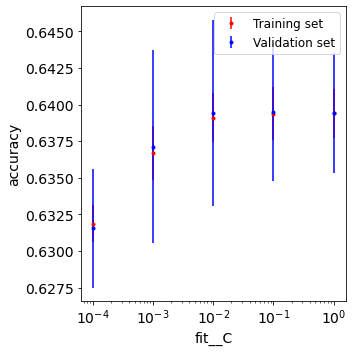

In [36]:
ml.plot_pars_scores(grid)

In [ ]:
# Logit: 0.639427 (underfitting)
# RF: 0.641506

#### Ajuste do modelo

In [37]:
dump = model.fit(X_train, y_train)

In [41]:
model.feature_names_in_

array(['DS_CARGO', 'DS_GENERO', 'DS_COR_RACA', 'DS_GRAU_INSTRUCAO',
       'NR_IDADE_DATA_POSSE', 'VALOR_TOTAL_BENS', 'FRAC_VOTOS'],
      dtype=object)

In [45]:
processor = model['proc']

In [56]:
enc = processor.transformers_[0][1]['enc']

In [62]:
list(enc.get_feature_names_out()) + ord_cols + num_cols + log_cols

['DS_CARGO_2º SUPLENTE',
 'DS_CARGO_DEPUTADO DISTRITAL',
 'DS_CARGO_DEPUTADO ESTADUAL',
 'DS_CARGO_DEPUTADO FEDERAL',
 'DS_CARGO_GOVERNADOR',
 'DS_CARGO_PRESIDENTE',
 'DS_CARGO_SENADOR',
 'DS_CARGO_VICE-GOVERNADOR',
 'DS_CARGO_VICE-PRESIDENTE',
 'DS_GENERO_MASCULINO',
 'DS_COR_RACA_BRANCA',
 'DS_COR_RACA_INDÍGENA',
 'DS_COR_RACA_NÃO INFORMADO',
 'DS_COR_RACA_PARDA',
 'DS_COR_RACA_PRETA',
 'DS_GRAU_INSTRUCAO',
 'NR_IDADE_DATA_POSSE',
 'VALOR_TOTAL_BENS',
 'FRAC_VOTOS']

In [66]:
feat_names = ['DS_CARGO_2º SUPLENTE', 'DS_CARGO_DEPUTADO DISTRITAL', 'DS_CARGO_DEPUTADO ESTADUAL', 'DS_CARGO_DEPUTADO FEDERAL', 'DS_CARGO_GOVERNADOR', 
              'DS_CARGO_PRESIDENTE', 'DS_CARGO_SENADOR', 'DS_CARGO_VICE-GOVERNADOR', 'DS_CARGO_VICE-PRESIDENTE', 'DS_GENERO_MASCULINO', 'DS_COR_RACA_BRANCA', 
              'DS_COR_RACA_INDÍGENA', 'DS_COR_RACA_NÃO INFORMADO', 'DS_COR_RACA_PARDA', 'DS_COR_RACA_PRETA', 'DS_GRAU_INSTRUCAO', 
              'NR_IDADE_DATA_POSSE', 'VALOR_TOTAL_BENS', 'FRAC_VOTOS']
logit = model['fit']
pd.Series(logit.coef_[0], index=feat_names).sort_values()

DS_CARGO_DEPUTADO DISTRITAL   -0.623789
DS_CARGO_VICE-GOVERNADOR      -0.468281
FRAC_VOTOS                    -0.457312
DS_COR_RACA_INDÍGENA          -0.362562
DS_CARGO_GOVERNADOR           -0.360791
DS_COR_RACA_BRANCA            -0.312710
DS_CARGO_PRESIDENTE           -0.250122
DS_CARGO_VICE-PRESIDENTE      -0.243062
VALOR_TOTAL_BENS              -0.217478
DS_CARGO_DEPUTADO FEDERAL     -0.210549
DS_CARGO_DEPUTADO ESTADUAL    -0.183496
DS_GRAU_INSTRUCAO             -0.131619
DS_COR_RACA_PRETA             -0.105457
DS_COR_RACA_PARDA              0.020993
DS_CARGO_SENADOR               0.090963
DS_GENERO_MASCULINO            0.131152
NR_IDADE_DATA_POSSE            0.165459
DS_CARGO_2º SUPLENTE           0.249998
DS_COR_RACA_NÃO INFORMADO      0.679155
dtype: float64

In [67]:
features_df.head()

,DS_CARGO,DS_GENERO,DS_COR_RACA,DS_GRAU_INSTRUCAO,NR_IDADE_DATA_POSSE,VALOR_TOTAL_BENS,FRAC_VOTOS,nenhuma
0,1º SUPLENTE,MASCULINO,BRANCA,SUPERIOR COMPLETO,55.0,699732.33,NaN,0
1,DEPUTADO FEDERAL,MASCULINO,BRANCA,ENSINO MÉDIO COMPLETO,54.0,17000.00,1379.869927,0
2,DEPUTADO ESTADUAL,MASCULINO,BRANCA,SUPERIOR COMPLETO,51.0,43150.00,74105.615392,1
3,DEPUTADO ESTADUAL,FEMININO,PRETA,ENSINO MÉDIO COMPLETO,36.0,0.00,10747.881401,1
4,DEPUTADO ESTADUAL,MASCULINO,PARDA,ENSINO MÉDIO COMPLETO,34.0,200000.00,4899.452708,1


In [2]:
import xavy.causal as xc

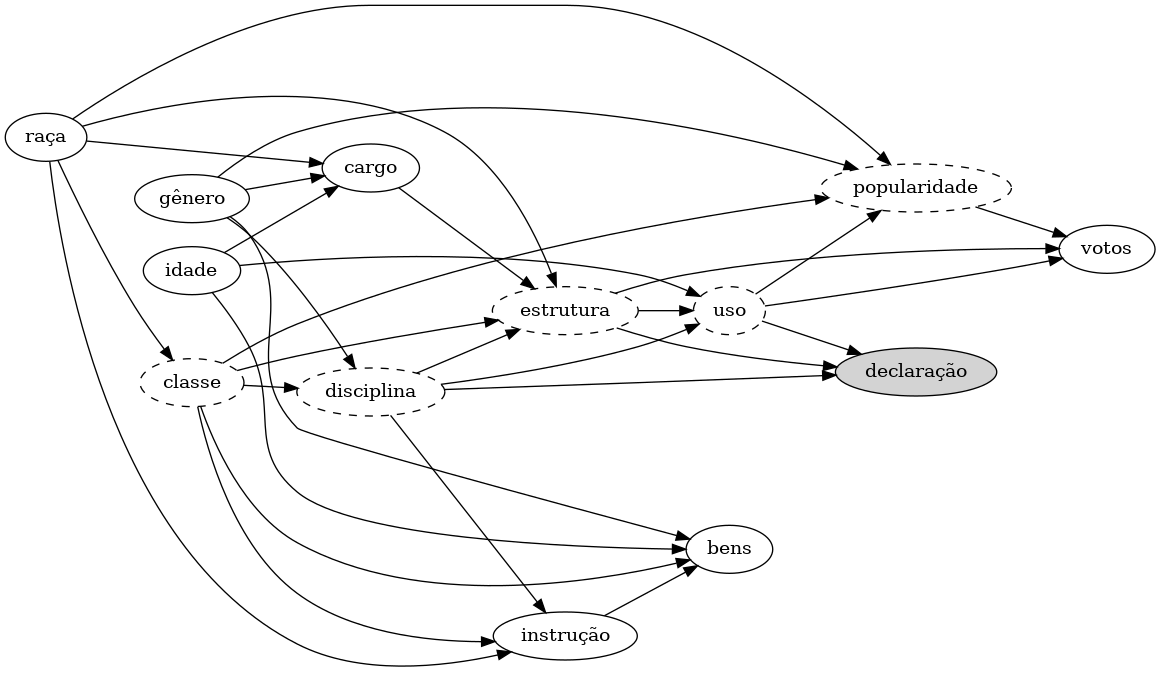

In [5]:
causal_links = [('cargo', 'estrutura'), ('classe', 'instrução'), ('classe', 'disciplina'), ('disciplina', 'uso'), ('idade', 'uso'), 
                 ('classe', 'bens'), ('classe', 'estrutura'), ('estrutura', 'uso'), ('uso', 'votos'), ('estrutura', 'votos'), ('raça', 'classe'), 
                 ('popularidade', 'votos'), ('uso', 'popularidade'), ('raça', 'popularidade'), ('gênero', 'popularidade'), ('gênero', 'bens'),
                 ('gênero', 'disciplina'), ('idade', 'bens'), ('idade', 'cargo'), ('raça', 'instrução'), ('raça', 'cargo'), ('gênero', 'cargo'),
                 ('classe', 'popularidade'), ('disciplina', 'estrutura'), ('instrução', 'bens'), ('disciplina', 'instrução'), ('uso', 'declaração'),
                 ('disciplina', 'declaração'), ('estrutura', 'declaração'), ('raça', 'estrutura')]
special_nodes = {'hidden':['disciplina', 'classe', 'estrutura', 'popularidade', 'uso'], 'target':'declaração'}
xc.plot_diagram(causal_links, special_nodes)